##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/332ewjf1fjmod77c4r2b7c1zq8j1a9pp)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Find the data for this project here: https://drive.google.com/drive/folders/1DRiIxfj5G6VzfHr1ojXxeE1YdLbae5xH?usp=sharing and store a copy in your google drive.  

Make sure that the 'project_data' folder is stored in the top level of your google drive.  Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import Audio
from numpy.core.fromnumeric import ndim
import torchaudio

import numpy as np
from glob import glob
from tqdm import tqdm
from pathlib import Path
import soundfile as sf
import re

sr = 44100

In [3]:
import pandas as pd

## 2. Label Extraction

**Function to Extract Labels From Files**

In [4]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

# Retrieve Labels for Model Testing

In [5]:
#First we obtain the list of all files in the train_clean directory and the 
#augmented directories
train_files = glob('drive/MyDrive/project_data/train_clean/*.wav')

#Let's sort it so that we're all using the same file list order
train_files.sort()

train_label=[]


for wav in tqdm(train_files):
  train_label.append(get_label(wav))

100%|██████████| 4372/4372 [00:00<00:00, 753822.95it/s]


In [6]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('drive/MyDrive/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort() 

test_clean_label=[]


for wav in tqdm(test_clean_files):
  test_clean_label.append(get_label(wav))

100%|██████████| 447/447 [00:00<00:00, 594248.46it/s]


In [7]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('drive/MyDrive/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort() 

test_noisy_label=[]


for wav in tqdm(test_noisy_files):
  test_noisy_label.append(get_label(wav))

100%|██████████| 347/347 [00:00<00:00, 618539.52it/s]


In [8]:
#Librosa features

train_feat_df1 = pd.read_csv('drive/MyDrive/train_feat_mfcc20_spectro_rolloff.csv', index_col=0)
test_clean_feat_df1 = pd.read_csv('drive/MyDrive/test_clean_feat_mfcc20_spectro_rolloff.csv', index_col=0)
test_noisy_feat_df1 = pd.read_csv('drive/MyDrive/test_noise_feat_mfcc20_spectro_rolloff.csv', index_col=0)

#OpenSmile ComParE features

train_feat_df2 = pd.read_csv('drive/MyDrive/train_feat_ComParE.csv', index_col=0)
test_clean_feat_df2 = pd.read_csv('drive/MyDrive/test_clean_feat_ComParE.csv', index_col=0)
test_noisy_feat_df2 = pd.read_csv('drive/MyDrive/test_noise_feat_ComParE.csv', index_col=0)

#Spafe PNCC features

train_feat_df3 = pd.read_csv('drive/MyDrive/train_feat_pncc.csv', index_col=0)
test_clean_feat_df3 = pd.read_csv('drive/MyDrive/test_clean_feat_pncc.csv', index_col=0)
test_noisy_feat_df3 = pd.read_csv('drive/MyDrive/test_noise_feat_pncc.csv', index_col=0)

#Spafe PLP features

train_feat_df4 = pd.read_csv('drive/MyDrive/train_feat_plp.csv', index_col=0)
test_clean_feat_df4 = pd.read_csv('drive/MyDrive/test_clean_feat_plp.csv', index_col=0)
test_noisy_feat_df4 = pd.read_csv('drive/MyDrive/test_noise_feat_plp.csv', index_col=0)

In [9]:
#Concatentate feature sets (Librosa + ComParE + PLP)

train_feat_df = pd.concat([train_feat_df1, train_feat_df2, train_feat_df4], ignore_index=False, axis=1)
test_clean_feat_df = pd.concat([test_clean_feat_df1, test_clean_feat_df2, test_clean_feat_df4], ignore_index=False, axis=1)
test_noisy_feat_df = pd.concat([test_noisy_feat_df1, test_noisy_feat_df2, test_noisy_feat_df4], ignore_index=False, axis=1)

## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [10]:
#Install shap library
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 14.0 MB/s eta 0:00:00


In [11]:
import xgboost
import shap


#Convert label lists for training

y_train=np.stack(train_label)

y_test_clean=np.stack(test_clean_label)

y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.8859060402684564
Test Noisy Acc = 0.6685878962536023


## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


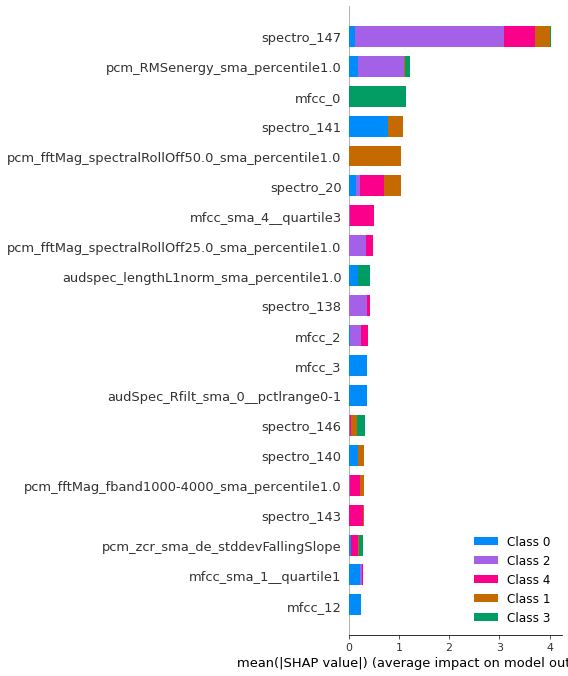

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

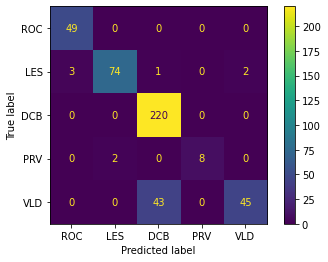

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

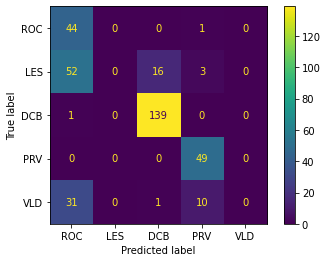

In [17]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()